In [1]:
import numpy as np
import pandas as pd
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(0)

In [2]:
file_path = 'modified_dataset/us_project_heatmap_remove_outliers.csv'

us_ds = pd.read_csv(file_path, sep=',')

In [3]:
us_ds.head(100)

,intercept,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,price_increased_yoy,inventory_turnover,sale_to_list_ppsf_ratio,supply_demand_balance,fast_selling,sin_year,cos_year,sin_month,cos_month,normalized_median_sale_price
0,1.0,2017-09-01,2017-09-30,30,place,6,29470,f,"Chicago, IL",Chicago,...,1,-0.659877,-0.223963,3.247222,0,0.573151,1.273751,-1.345297,0.094627,0.039266
1,1.0,2020-07-01,2020-07-31,30,place,6,37598,f,"Parsippany, NJ",Parsippany,...,0,0.591989,-0.005179,0.179183,0,1.103099,-0.638699,-0.637291,-1.137098,0.073469
2,1.0,2021-08-01,2021-08-31,30,place,6,24993,f,"Oakbrook, KY",Oakbrook,...,1,3.177449,-0.029312,0.179183,1,0.573151,-1.151138,-1.155588,-0.616510,0.040100
3,1.0,2018-08-01,2018-08-31,30,place,6,29754,f,"Dunstable, MA",Dunstable,...,0,-0.183649,0.082212,0.002180,0,1.103099,0.761311,-1.155588,-0.616510,0.079157
4,1.0,2023-01-01,2023-01-31,30,place,6,10728,f,"Kalamazoo, MI",Kalamazoo,...,1,-0.142691,0.004767,-0.469826,1,-0.874693,-1.151138,0.778721,1.326353,0.028345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1.0,2024-07-01,2024-07-31,30,place,6,16583,f,"Saco, ME",Saco,...,0,0.074897,0.079835,-0.115821,1,-1.404641,-0.638699,-0.637291,-1.137098,0.085983
96,1.0,2020-01-01,2020-01-31,30,place,6,10233,f,"Lancaster, CA",Lancaster,...,1,0.066610,0.008287,-2.180848,0,1.103099,-0.638699,0.778721,1.326353,0.045409
97,1.0,2013-09-01,2013-09-30,30,place,6,24533,f,"Ocean Bluff-Brant Rock, MA",Ocean Bluff-Brant Rock,...,0,-0.839473,-0.057222,-0.174822,0,-1.598615,0.061306,-1.345297,0.094627,0.032327
98,1.0,2024-06-01,2024-06-30,30,place,6,15188,f,"Ogden, IA",Ogden,...,1,0.998275,0.330595,-0.115821,0,-1.404641,-0.638699,0.070715,-1.327647,0.041389


In [4]:
print(us_ds.shape)

(1789138, 74)


In [5]:
def split_data(us_ds, state_column, ratio=0.8):
    # Initialize lists to hold the train and test splits for features and targets
    X_train_data = []
    y_train_data = []
    X_test_data = []
    y_test_data = []
    
    # Group by the state column
    grouped = us_ds.groupby(state_column)
    
    for state, group in grouped:
        # Split the group into X (features) and y (target)
        X_group = group.drop(columns=['median_sale_price'])
        y_group = group['median_sale_price']
        
        # Get the number of samples and calculate the number of training samples
        num_samples = len(group)
        n_train = int(num_samples * ratio)
        
        # Shuffle the indices for randomization
        indices = np.random.permutation(num_samples)
        
        train_indices = indices[:n_train]
        test_indices = indices[n_train:]
        
        # Split into train and test data for both X and y
        X_train_group = X_group.iloc[train_indices]
        y_train_group = y_group.iloc[train_indices]
        X_test_group = X_group.iloc[test_indices]
        y_test_group = y_group.iloc[test_indices]
        
        # Append the data for this group to the lists
        X_train_data.append(X_train_group)
        y_train_data.append(y_train_group)
        X_test_data.append(X_test_group)
        y_test_data.append(y_test_group)
    
    # Concatenate all the groups to form the final train and test datasets
    X_train = pd.concat(X_train_data).reset_index(drop=True)
    y_train = pd.concat(y_train_data).reset_index(drop=True)
    X_test = pd.concat(X_test_data).reset_index(drop=True)
    y_test = pd.concat(y_test_data).reset_index(drop=True)
    
    return X_train, y_train, X_test, y_test

In [6]:
# Split the data
X_train, y_train, X_test, y_test = split_data(us_ds, 'state_code')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1431289, 73)
(1431289,)
(357849, 73)
(357849,)


In [7]:
string_columns_x_train = X_train.select_dtypes(include='object').columns
# string_columns_y_train = y_train.select_dtypes(include='object').columns
string_columns_x_test = X_test.select_dtypes(include='object').columns
# string_columns_y_test = y_test.select_dtypes(include='object').columns

print(string_columns_x_train)
# print(string_columns_y_train)
print(string_columns_x_test)
# print(string_columns_y_test)

Index(['period_begin', 'period_end', 'region_type', 'is_seasonally_adjusted',
       'region', 'city', 'state', 'state_code', 'property_type',
       'parent_metro_region', 'last_updated'],
      dtype='object')
Index(['period_begin', 'period_end', 'region_type', 'is_seasonally_adjusted',
       'region', 'city', 'state', 'state_code', 'property_type',
       'parent_metro_region', 'last_updated'],
      dtype='object')


In [8]:
exclude_columns = [
    'period_begin', 'period_end', 'region_type', 'is_seasonally_adjusted', 'parent_metro_region', 'last_updated', 'state', 'city', 'region'
]

if exclude_columns:
    columns_for_encoding = [col for col in string_columns_x_train if col not in exclude_columns]
else:
    columns_for_encoding = string_columns_x_train
    
print(columns_for_encoding)

['state_code', 'property_type']


In [9]:
import category_encoders as ce

# Apply Binary Encoding
binary_encoder = ce.BinaryEncoder(cols=columns_for_encoding)
X_train_binary = binary_encoder.fit_transform(X_train)
# y_train_binary = binary_encoder.fit_transform(y_train)
X_test_binary = binary_encoder.fit_transform(X_test)
# y_test_binary = binary_encoder.fit_transform(y_test)

In [10]:
X_train_binary.head(50)

,intercept,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,price_increased_yoy,inventory_turnover,sale_to_list_ppsf_ratio,supply_demand_balance,fast_selling,sin_year,cos_year,sin_month,cos_month,normalized_median_sale_price
0,1.0,2022-04-01,2022-04-30,30,place,6,781,f,"Anchorage, AK",Anchorage,...,1,1.178447,0.003249,1.772203,1,-0.150771,-1.338704,1.297017,-0.616510,0.053751
1,1.0,2022-07-01,2022-07-31,30,place,6,23973,f,"Lakes, AK",Lakes,...,1,0.035723,0.117578,0.415186,1,-0.150771,-1.338704,-0.637291,-1.137098,0.078998
2,1.0,2023-05-01,2023-05-31,30,place,6,24304,f,"Meadow Lakes, AK",Meadow Lakes,...,1,0.027018,-0.065214,0.415186,1,-0.874693,-1.151138,0.778721,-1.137098,0.052993
3,1.0,2024-07-01,2024-07-31,30,place,6,37377,f,"South Lakes, AK",South Lakes,...,0,0.150940,0.000387,0.120182,1,-1.404641,-0.638699,-0.637291,-1.137098,0.067099
4,1.0,2024-05-01,2024-05-31,30,place,6,6233,f,"Fairbanks, AK",Fairbanks,...,0,0.470631,-0.038828,1.123195,1,-1.404641,-0.638699,0.778721,-1.137098,0.043892
5,1.0,2021-08-01,2021-08-31,30,place,6,26777,f,"Willow, AK",Willow,...,0,-0.479130,0.164174,0.179183,1,0.573151,-1.151138,-1.155588,-0.616510,0.030999
6,1.0,2024-05-01,2024-05-31,30,place,6,23973,f,"Lakes, AK",Lakes,...,0,-0.318543,-0.092019,0.002180,1,-1.404641,-0.638699,0.778721,-1.137098,0.058453
7,1.0,2024-08-01,2024-08-31,30,place,6,23792,f,"Knik-Fairview, AK",Knik-Fairview,...,1,-0.339752,-0.025581,0.238183,0,-1.404641,-0.638699,-1.155588,-0.616510,0.060122
8,1.0,2023-11-01,2023-11-30,30,place,6,14473,f,"North Pole, AK",North Pole,...,1,0.150940,0.003137,-0.056821,0,-0.874693,-1.151138,-0.637291,1.326353,0.046910
9,1.0,2022-06-01,2022-06-30,30,place,6,22951,f,"Gateway, AK",Gateway,...,0,-0.309428,0.035363,0.238183,1,-0.150771,-1.338704,0.070715,-1.327647,0.071953


In [11]:
X_test_binary.head(50)

,intercept,period_begin,period_end,period_duration,region_type,region_type_id,table_id,is_seasonally_adjusted,region,city,...,price_increased_yoy,inventory_turnover,sale_to_list_ppsf_ratio,supply_demand_balance,fast_selling,sin_year,cos_year,sin_month,cos_month,normalized_median_sale_price
0,1.0,2024-05-01,2024-05-31,30,place,6,23792,f,"Knik-Fairview, AK",Knik-Fairview,...,1,-0.259179,0.049325,1.595201,1,-1.404641,-0.638699,0.778721,-1.137098,0.057543
1,1.0,2022-07-01,2022-07-31,30,place,6,26181,f,"Sutton-Alpine, AK",Sutton-Alpine,...,0,0.850535,-0.031851,0.120182,0,-0.150771,-1.338704,-0.637291,-1.137098,0.032364
2,1.0,2023-06-01,2023-06-30,30,place,6,26218,f,"Tanaina, AK",Tanaina,...,1,0.591989,-0.017654,0.179183,1,-0.874693,-1.151138,0.070715,-1.327647,0.054813
3,1.0,2021-11-01,2021-11-30,30,place,6,22951,f,"Gateway, AK",Gateway,...,0,0.678171,-0.023619,-0.469826,0,0.573151,-1.151138,-0.637291,1.326353,0.061790
4,1.0,2021-08-01,2021-08-31,30,place,6,6233,f,"Fairbanks, AK",Fairbanks,...,0,-0.279561,-0.002063,-0.115821,0,0.573151,-1.151138,-1.155588,-0.616510,0.036308
5,1.0,2024-08-01,2024-08-31,30,place,6,26205,f,"Talkeetna, AK",Talkeetna,...,1,-0.643286,0.328921,-0.056821,0,-1.404641,-0.638699,-1.155588,-0.616510,0.056178
6,1.0,2021-08-01,2021-08-31,30,place,6,8643,f,"Houston, AK",Houston,...,1,0.936717,0.440974,-0.115821,1,0.573151,-1.151138,-1.155588,-0.616510,0.030999
7,1.0,2024-02-01,2024-02-29,30,place,6,31590,f,"Badger, AK",Badger,...,1,-0.227657,-0.051401,0.179183,0,-1.404641,-0.638699,1.297017,0.805764,0.050331
8,1.0,2023-05-01,2023-05-31,30,place,6,22163,f,"College, AK",College,...,0,0.911369,-0.047931,-0.056821,1,-0.874693,-1.151138,0.778721,-1.137098,0.048056
9,1.0,2024-04-01,2024-04-30,30,place,6,22951,f,"Gateway, AK",Gateway,...,0,-0.938324,-0.065836,0.415186,1,-1.404641,-0.638699,1.297017,-0.616510,0.062094


In [12]:
columns_for_model = [
    'state_code_0', 'state_code_1', 'state_code_2', 'state_code_3', 'state_code_4', 'state_code_5', 'property_type_0', 'property_type_1', 'property_type_2', 'median_dom', 'price_drops', 'inventory_turnover', 'price_increased_mom', 'median_sale_price_mom', 'median_list_price', 'median_ppsf', 'median_list_ppsf', 'avg_sale_to_list', 'sold_above_list', 'sale_to_list_ratio', 'sin_year', 'cos_year', 'sin_month', 'cos_month'
]

X_train = X_train_binary[columns_for_model]
X_test = X_test_binary[columns_for_model]

In [13]:
X_train.head(100)

,state_code_0,state_code_1,state_code_2,state_code_3,state_code_4,state_code_5,property_type_0,property_type_1,property_type_2,median_dom,...,median_list_price,median_ppsf,median_list_ppsf,avg_sale_to_list,sold_above_list,sale_to_list_ratio,sin_year,cos_year,sin_month,cos_month
0,0,0,0,0,0,1,0,0,1,-0.844788,...,-0.031073,0.000760,-0.007148,0.949625,0.899253,-0.107585,-0.150771,-1.338704,1.297017,-0.616510
1,0,0,0,0,0,1,0,1,0,-0.738828,...,-0.049638,0.019582,-0.053106,1.122428,1.256489,0.691666,-0.150771,-1.338704,-0.637291,-1.137098
2,0,0,0,0,0,1,0,1,0,-0.650527,...,-0.007202,0.008549,0.070059,0.107928,-0.207976,-0.181935,-0.874693,-1.151138,0.778721,-1.137098
3,0,0,0,0,0,1,0,1,0,-0.738828,...,-0.005611,0.019817,0.027179,0.784549,1.225831,0.210472,-1.404641,-0.638699,-0.637291,-1.137098
4,0,0,0,0,0,1,0,0,1,-0.509246,...,-0.271543,-0.062828,-0.088205,-1.072131,-1.226734,0.303301,-1.404641,-0.638699,0.778721,-1.137098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,1,0,0,1,-0.191364,...,-0.160148,-0.003696,0.021487,-0.442858,-0.280745,0.231273,-0.150771,-1.338704,-1.345297,0.094627
96,0,0,0,0,0,1,0,1,0,-0.809468,...,-0.054943,-0.006901,0.023569,0.817539,0.980575,0.165935,-0.150771,-1.338704,1.297017,-0.616510
97,0,0,0,0,0,1,0,0,1,-0.632867,...,0.056452,0.020931,0.034192,-0.093546,0.428748,0.330251,-0.874693,-1.151138,0.070715,-1.327647
98,0,0,0,0,0,1,0,1,0,0.726961,...,-0.102772,-0.021229,-0.058625,0.053650,-1.056941,0.064305,0.573151,-1.151138,-0.637291,1.326353


In [14]:
X_test.head(100)

,state_code_0,state_code_1,state_code_2,state_code_3,state_code_4,state_code_5,property_type_0,property_type_1,property_type_2,median_dom,...,median_list_price,median_ppsf,median_list_ppsf,avg_sale_to_list,sold_above_list,sale_to_list_ratio,sin_year,cos_year,sin_month,cos_month
0,0,0,0,0,0,1,0,0,1,-0.703508,...,-0.005611,0.048915,0.033803,0.285572,0.378582,-0.057628,-1.404641,-0.638699,0.778721,-1.137098
1,0,0,0,0,0,1,0,0,1,-0.173704,...,-0.306022,-0.028816,-0.031261,-2.099475,-0.123080,-0.091328,-0.150771,-1.338704,-0.637291,-1.137098
2,0,0,0,0,0,1,0,0,1,-0.756488,...,-0.147064,-0.002119,0.004745,0.628816,0.349915,0.251020,-0.874693,-1.151138,0.070715,-1.327647
3,0,0,0,0,0,1,0,1,0,-0.120724,...,0.034350,-0.012859,-0.009258,0.168705,-0.424076,-0.031347,0.573151,-1.151138,-0.637291,1.326353
4,0,0,0,0,0,1,0,1,0,0.515040,...,-0.328301,-0.073853,-0.129313,0.307931,-1.128632,0.203969,0.573151,-1.151138,-1.155588,-0.616510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,1,0,1,0,-0.738828,...,-0.049638,0.004787,0.002389,0.590337,0.465536,-0.064259,-0.874693,-1.151138,1.486727,0.094627
96,0,0,0,0,0,1,0,0,1,-0.438606,...,-0.016043,-0.004800,-0.001950,0.523632,0.116845,-0.253696,-0.150771,-1.338704,0.778721,1.326353
97,0,0,0,0,0,1,0,1,0,-0.844788,...,-0.257397,-0.022533,-0.001009,1.376261,1.422037,0.307936,0.573151,-1.151138,-1.155588,0.805764
98,0,0,0,0,0,1,0,0,1,-0.526906,...,0.007826,-0.014796,0.037598,0.162369,0.131610,0.204548,-0.150771,-1.338704,-1.155588,-0.616510


In [15]:
# Convert to numpy arrays if X or y are DataFrames
X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train

X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
y_test = y_test.to_numpy() if isinstance(y_test, pd.DataFrame) else y_test

In [16]:
def add_intercept(X):
    #Input: X: a numpy array of shape (N, D), where N is the number of samples and D is the number of features
    #Output: X: a numpy array of shape (N, D+1), where a column of ones is concatenated to the input array X

    ########## Your code goes here ##########
    
    # adds ones column to the back of the matrix
    # x_with_bias = np.c_[X, np.ones(X.shape[0])]
    
    # adds ones column to the front of the matrix
    x_with_bias = np.c_[np.ones(X.shape[0]), X]
    X = x_with_bias
    
    # adds ones column to the front of the matrix
    # X = np.hstack((np.ones((X.shape[0], 1)), X))

    #########################################

    return X

In [17]:
X_train = add_intercept(X_train)
X_test = add_intercept(X_test)

In [18]:
print('The shape of the training set is:')
print(X_train.shape, y_train.shape)
print('The shape of the test set is:')
print(X_test.shape, y_test.shape)

The shape of the training set is:
(1431289, 25) (1431289,)
The shape of the test set is:
(357849, 25) (357849,)


In [19]:
# Function to compute mean absolute error (MAE) and R² score
def compute_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, r2

def predict(X, w):

    # Input: X: a numpy array of shape (N, D), where N is the number of samples and D is the number of features
    #        w: a numpy array of shape (D,), containing the weights of the linear model
    # Output: pred: a numpy array of shape (N,), containing the predicted values for the input data

    pred = None

    ########## Your code goes here ##########

    weighted_sum = np.dot(X, w)
    pred = weighted_sum

    #########################################

    return pred

def compute_loss(X, y, w):

    # Input: X: a numpy array of shape (N, D), where N is the number of samples and D is the number of features
    #        y: a numpy array of shape (N,), containing the target for each sample
    #        w: a numpy array of shape (D,), containing the weights of the linear model
    # Output: loss: a float number representing the average loss

    loss = None

    ########## Your code goes here ##########

    # get predictions from the model
    pred = predict(X, w)
    
    # calculate the squared errors
    squared_errors = (y - pred) ** 2
    
    # calculate the loss function
    loss = 1/2 * np.sum(squared_errors)
    
    #########################################

    return loss

In [20]:
def compute_gradient_single(x_i, y_i, w):

    grad = None 

    ########## Your code goes here ##########

    # The gradient of the loss with respect to the weights, for one data point (xi,yi) is given by: xi * (predict(xi,w) - yi)
    prediction = predict(x_i, w)
    grad = x_i * (prediction - y_i)
    grad = np.clip(grad, -1e5, 1e5)

    #########################################

    return grad

def compute_gradient_batch(X, y, w):

    grad = None

    ########## Your code goes here ##########

    # For batch gradient descent, we compute the gradient for the entire dataset. The gradient formula for the full batch is: 
    # X(transpose) @ (predict(X,w) - y)
    predictions = predict(X, w)
    grad = X.T @ (predictions - y)
    grad = np.clip(grad, -1e5, 1e5)

    #########################################

    return grad

def train_stochastic(X, y, w, alpha, no_iterations):

    # Input: X: a numpy array of shape (N, D), where N is the number of samples and D is the number of features
    #        y: a numpy array of shape (N,), containing the target for each sample
    #        w: a numpy array of shape (D,), containing the weights of the linear model
    #        alpha: a float number representing the learning rate
    #        no_iterations: an integer representing the number of iterations
    # Output: w: a numpy array of shape (D,), the weights of the trained linear model
    #         losses: a list of floats containing the loss at each update
    print(f"len y: {len(y)}")

    losses = []
    predictions_list = []

    for k in range(no_iterations):

        ########## Your code goes here ##########
        
        for i in range(len(y)):
            
            # compute the gradient for the current example
            gradient = compute_gradient_single(X[i], y[i], w)
            
            # update weights
            w = w - alpha * gradient
            
        # calculate and store the current loss
        current_loss = compute_loss(X, y, w)
        predictions = predict(X, w)
        predictions_list.append(predictions)
        
        print(f'Iteration {k}: Loss = {current_loss}')
        losses.append(current_loss)

        #########################################

    predictions_stochastic = np.array(predictions_list[-1])  # Get predictions after the last iteration
    return w, losses, predictions_stochastic

def train_batch(X, y, w, alpha, no_iterations):

    # Input: X: a numpy array of shape (N, D), where N is the number of samples and D is the number of features
    #        y: a numpy array of shape (N,), containing the target for each sample
    #        w: a numpy array of shape (D,), containing the weights of the linear model
    #        alpha: a float number representing the learning rate
    #        no_iterations: an integer representing the number of iterations
    # Output: w: a numpy array of shape (D,), the weights of the trained linear model
    #         losses: a list of floats containing the loss at each update

    losses = []
    predictions_list = []

    print("Train Batch")
    for step in range(no_iterations):

        ########## Your code goes here ##########

        # compute batch gradient
        gradient = compute_gradient_batch(X, y, w)
        
        # update weights
        w = w - alpha * gradient
        
        # calculate and store the current loss
        current_loss = compute_loss(X, y, w)
        predictions = predict(X, w)
        predictions_list.append(predictions)
        
        print(f'Iteration {step}: Loss = {current_loss}')
        losses.append(current_loss)

        #########################################

    predictions_batch = np.array(predictions_list[-1])  # Get predictions after the last iteration
    return w, losses, predictions_batch

def test(X, y, w):

    loss = None
    
    ########## Your code goes here ##########

    loss = compute_loss(X, y, w)
    predictions = predict(X, w)
    
    # Compute MAE and R² score
    mae, r2 = compute_metrics(y, predictions)
    
    print(f'Mean Absolute Error: {mae}')
    print(f'R² Score: {r2}')
    
    # Plot actual vs predicted values
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=predictions)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)  # Diagonal reference line
    plt.grid(True)
    plt.show()

    ######################################### 

    return loss, predictions, mae, r2

len y: 1431289
Iteration 0: Loss = 686357.0936175914
Iteration 1: Loss = 676867.5583938733
Iteration 2: Loss = 667733.01740381
Iteration 3: Loss = 658938.5374985822
Iteration 4: Loss = 650469.9017745757
Iteration 5: Loss = 642313.5704650793
Iteration 6: Loss = 634456.6442043441
Iteration 7: Loss = 626886.8295093613
Iteration 8: Loss = 619592.4063351718
Iteration 9: Loss = 612562.197569314
Iteration 10: Loss = 605785.540340344
Iteration 11: Loss = 599252.259023444
Iteration 12: Loss = 592952.6398345629
Iteration 13: Loss = 586877.406911367
Iteration 14: Loss = 581017.6997865223
Iteration 15: Loss = 575365.0521649126
Iteration 16: Loss = 569911.3719224108
Iteration 17: Loss = 564648.9222494343
Iteration 18: Loss = 559544.4253371237
Iteration 19: Loss = 554592.406352651
Iteration 20: Loss = 549787.903320147
Iteration 21: Loss = 545126.1584247433
Iteration 22: Loss = 540602.6076630182
Iteration 23: Loss = 536212.871100833
Iteration 24: Loss = 531952.7436995964
Mean Absolute Error: 0.550129

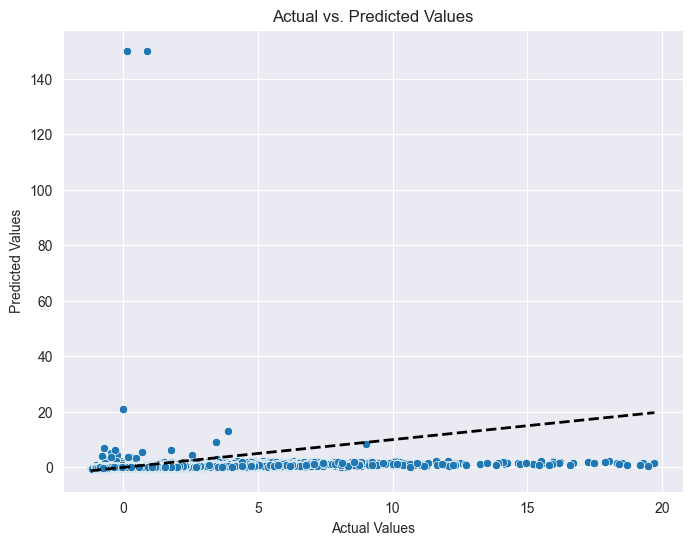

Stochastic Gradient Descent loss on test: 152146.12177434913


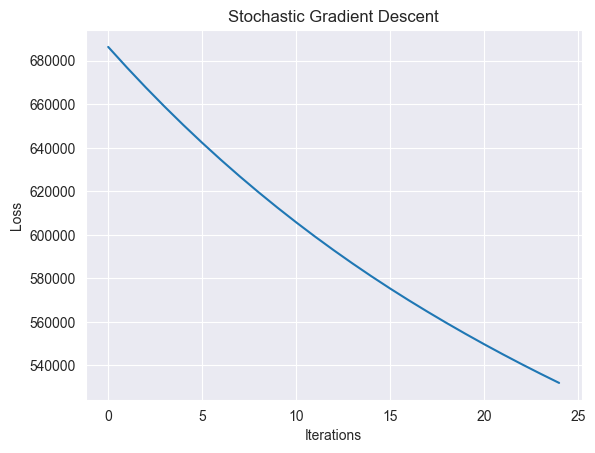

In [21]:
### Let's train and test our models

w_stochastic = np.random.randn(X_train.shape[1]) * 0.01
alpha = 1e-8

w_stochastic, losses_stochastic, predictions_stochastic = train_stochastic(X_train, y_train, w_stochastic, alpha, no_iterations=25)

loss_stochastic, predictions_stochastic_test, mae_stochastic, r2_stochastic = test(X_test, y_test, w_stochastic)

print(f'Stochastic Gradient Descent loss on test: {loss_stochastic}')

plt.figure()
plt.plot(losses_stochastic)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Stochastic Gradient Descent')
plt.show()

Train Batch
Iteration 0: Loss = 682621.2840535251
Iteration 1: Loss = 657402.9911987222
Iteration 2: Loss = 635136.527366741
Iteration 3: Loss = 615335.3100281497
Iteration 4: Loss = 597731.7292382803
Iteration 5: Loss = 582005.5683418332
Iteration 6: Loss = 567897.9778106221
Iteration 7: Loss = 555349.5640834654
Iteration 8: Loss = 544161.264930233
Iteration 9: Loss = 534065.3469043656
Iteration 10: Loss = 524861.8811362168
Iteration 11: Loss = 516411.19088311226
Iteration 12: Loss = 508706.6558543523
Iteration 13: Loss = 501627.9982678063
Iteration 14: Loss = 495050.7290868656
Iteration 15: Loss = 488884.9752622642
Iteration 16: Loss = 483065.50029022625
Iteration 17: Loss = 477544.68503935414
Iteration 18: Loss = 472287.5580169464
Iteration 19: Loss = 467268.2600805847
Iteration 20: Loss = 462467.5204799169
Iteration 21: Loss = 457870.84952215286
Iteration 22: Loss = 453467.2409160766
Iteration 23: Loss = 449248.2376669918
Iteration 24: Loss = 445207.25792789477
Iteration 25: Loss =

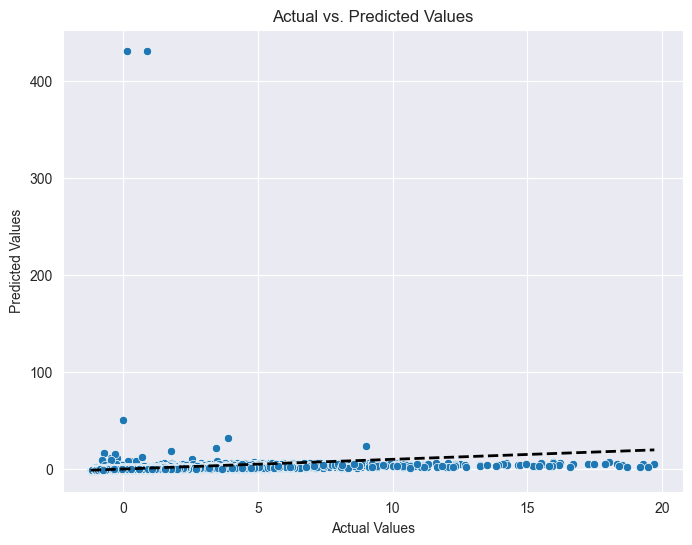

Batch Gradient Descent loss on test: 262659.4490864291


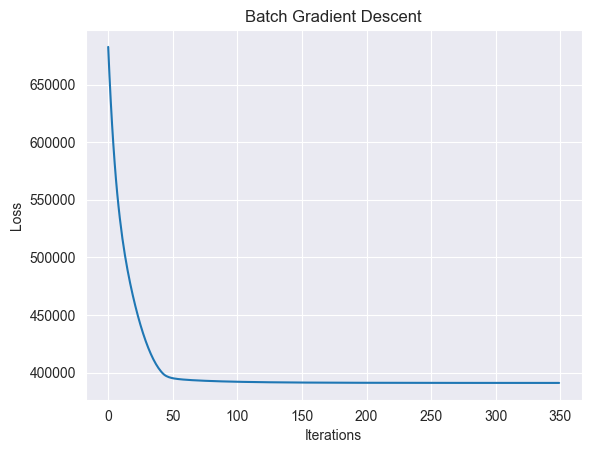

In [22]:
w_batch = np.random.randn(X_train.shape[1]) * 0.01
alpha = 1e-7

w_batch, losses_batch, predictions_batch = train_batch(X_train, y_train, w_batch, alpha, no_iterations=350)

loss_batch, predictions_batch_test, mae_batch, r2_batch = test(X_test, y_test, w_batch)

print(f'Batch Gradient Descent loss on test: {loss_batch}')

plt.figure()
plt.plot(losses_batch)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Batch Gradient Descent')
plt.show()

Stochastic Gradient Descent loss on test: 0.4251684978142991
Batch Gradient Descent loss on test: 0.7339952021283532


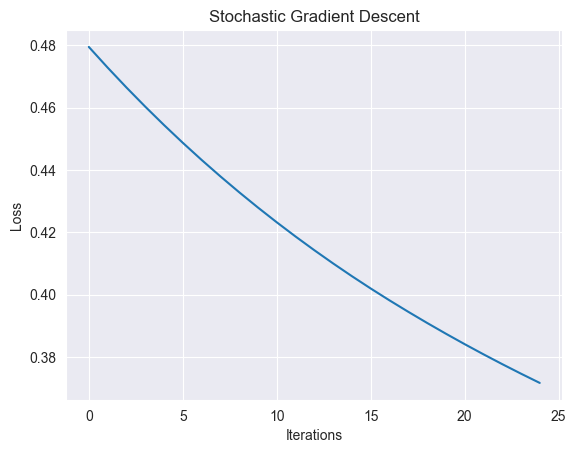

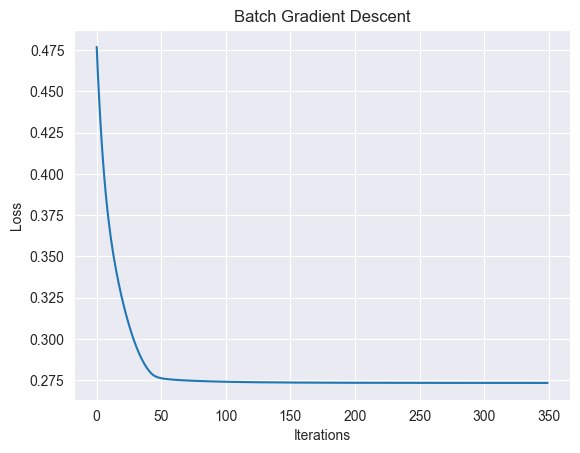

In [23]:
#for each loss in the array losses_stochastic, divide it by the number of samples in the training set
losses_stochastic = [loss / X_train.shape[0] for loss in losses_stochastic]
#for each loss in the array losses_batch, divide it by the number of samples in the training set
losses_batch = [loss / X_train.shape[0] for loss in losses_batch]

loss_stochastic = loss_stochastic / X_test.shape[0]
loss_batch = loss_batch / X_test.shape[0]

print(f'Stochastic Gradient Descent loss on test: {loss_stochastic}')
print(f'Batch Gradient Descent loss on test: {loss_batch}')

#Plot side by side the losses of the two algorithms should be 2 different figures
plt.figure()
plt.plot(losses_stochastic)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Stochastic Gradient Descent')
plt.show()

plt.figure()
plt.plot(losses_batch)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Batch Gradient Descent')
plt.show()

In [25]:
def get_closed_form_solution(X_train, y_train):

    # Input: X_train: a numpy array of shape (N, D), where N is the number of samples and D is the number of features
    #        y_train: a numpy array of shape (N,), containing the target for each sample
    # Output: w: a numpy array of shape (D,), the weights of the trained linear model

    ########## Your code goes here ##########

    # XTX_inv = np.linalg.inv(X_train.T @ X_train)
    # XTy = X_train.T @ y_train
    # w = XTX_inv @ XTy

    w = np.linalg.inv(X_train.T @ X_train) @ X_train.T @ y_train

    #########################################

    return w

w_closed_form = get_closed_form_solution(X_train, y_train)
# y_pred = predict(X_test, w_closed_form)
# loss = test(X_test, y_test, w_closed_form) / X_test.shape[0]
# 
# print(f'Closed form solution loss on test: {loss}')

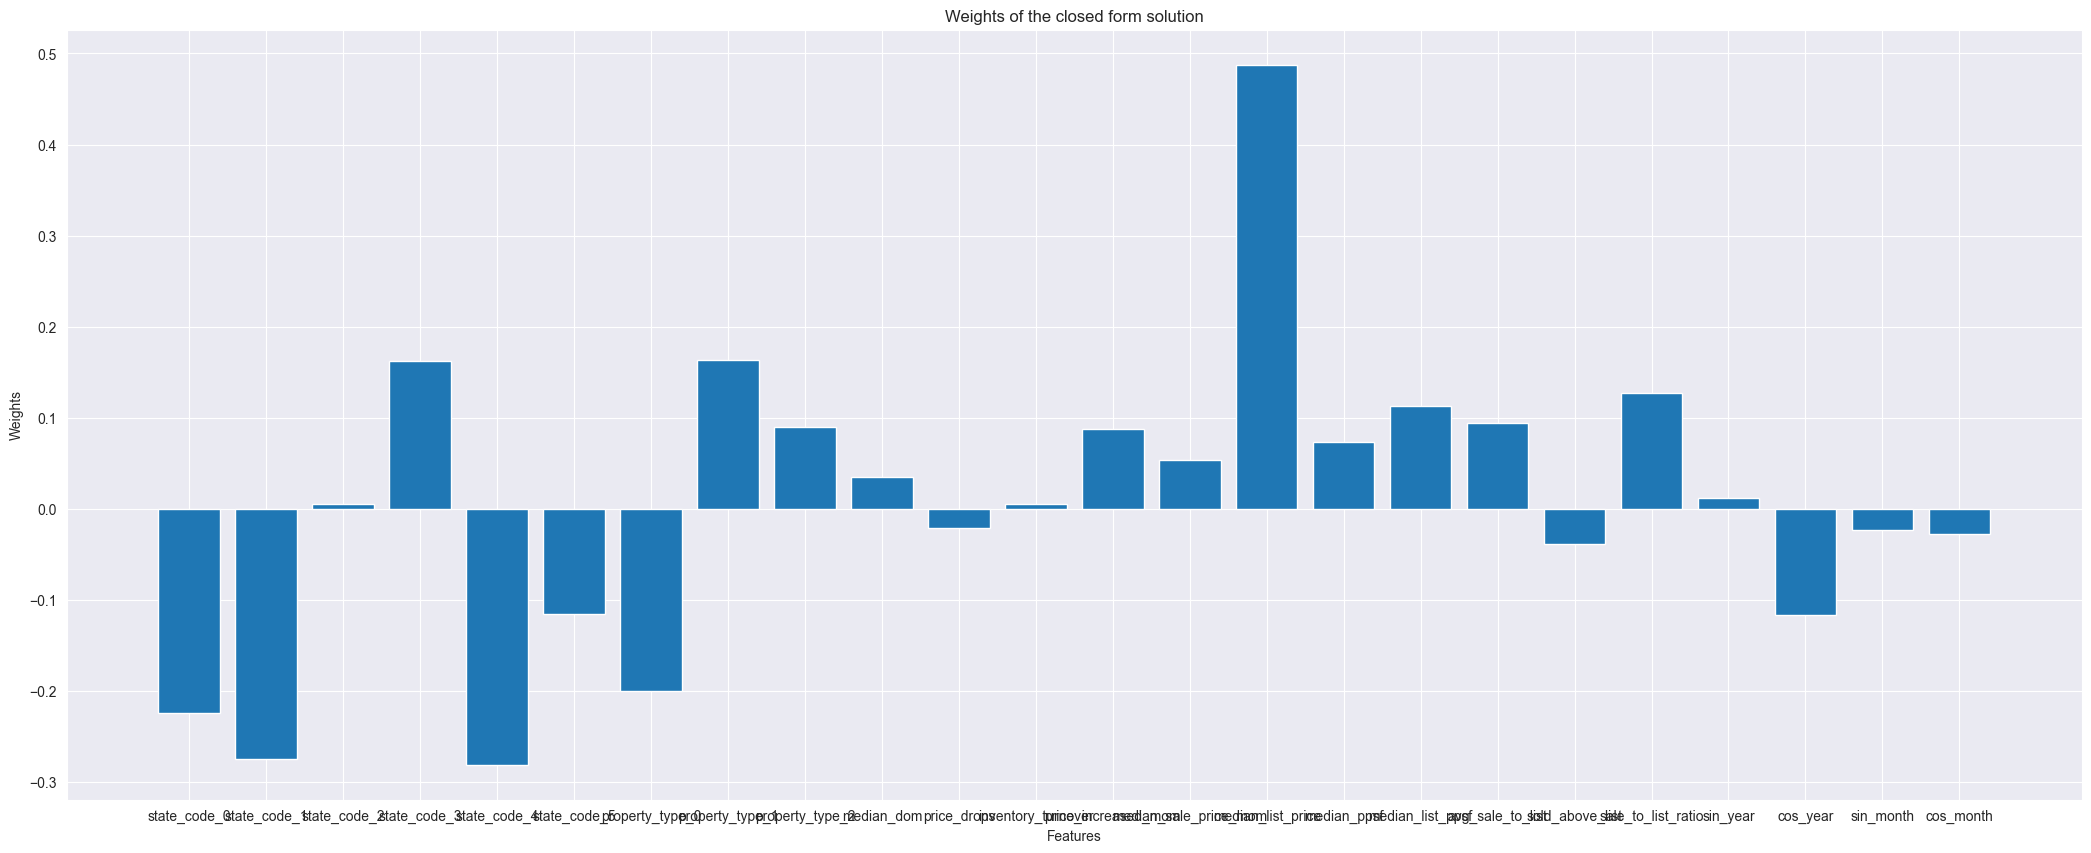

In [26]:
plt.figure(figsize=(26, 10))
plt.bar(columns_for_model, w_closed_form[1:])
plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('Weights of the closed form solution')
plt.show()